In [1]:
from datetime import datetime
from glob import glob
import json
import os

import cv2
from keras import losses, Model, optimizers, metrics
from keras.layers import Activation, Add, BatchNormalization, Concatenate, Conv2D, Dense, DepthwiseConv2D, Dropout, Flatten, Input, Reshape
from keras.losses import SparseCategoricalCrossentropy
# from keras.metrics import MeanSquaredError, SparseCategoricalAccuracy
from keras.utils import plot_model
from livelossplot import PlotLossesKeras, PlotLossesKerasTF
from matplotlib import pyplot as plt
from numpy import interp
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.preprocessing import label_binarize
import tensorflow as tf
import tensorflow.keras as k
from tensorflow.python.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.python.ops.image_ops_impl import *

from helper.dataset_mkr import *
from helper.eval_function import *
from helper.gpu_memmory import *
from helper.model import *

2022-10-26 01:49:38.509400: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-26 01:49:38.624457: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-26 01:49:39.140320: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/z/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-10-26 01:49:39.140365: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dle

In [2]:
# load tensorboard
%load_ext tensorboard


In [3]:
"""
0 CPU
1 필요한 만큼 메모리를 런타임에 할당
2 GPU에 할당되는 전체 메모리 크기를 제한
"""
set_gpu_memmory(1)

1 Physical GPUs, 1 Logical GPUs


2022-10-26 01:49:40.183308: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 01:49:40.187604: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 01:49:40.187847: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 01:49:40.188456: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [4]:
DEBUG = 1
LOAD_MODEL = 0
TENSORBOARD = 1
SAVE = 1

MIN, MAX = 0, 255

CLASS = 23
# RAW_CLASS = 23
# CLASS = RAW_CLASS+1  ## 1: BACKGROUND


# 1. DATASET

In [5]:
data_dir = f"/media/z/0/MVPC10/DATA/v1.1/RAW/03"
# file = f"label_1248_cnt.csv"
file = f"~/LABELING/v2.1_FINAL_REFINED.csv"
df = pd.read_csv(file)
# df.sort_values(by=df.keys()[0], inplace=True, ascending=True)
print(df)


                path                                              label
0      1650315736806                                     [[0, 0, 0, 0]]
1      1650315796123                                     [[0, 0, 0, 0]]
2      1650315856514                                     [[0, 0, 0, 0]]
3      1650315917006                                     [[0, 0, 0, 0]]
4      1650315976418                                     [[0, 0, 0, 0]]
...              ...                                                ...
86493  1661954116964  [[25, 41, 40, 67], [38, 32, 50, 60], [54, 43, ...
86494  1661954176336                                     [[0, 0, 0, 0]]
86495  1661954236769                                     [[0, 0, 0, 0]]
86496  1661954296445                [[15, 19, 31, 40], [26, 7, 33, 23]]
86497  1661954356730                                 [[13, 18, 31, 37]]

[86498 rows x 2 columns]


In [6]:
df.empty

False

In [7]:
df.values[:,1].dtype

dtype('O')

In [8]:
zero_value = 2  ## means 1/n
cnt0 = 0
path = []
label = []
for i in range(len(df.index)):
    bbox = json.loads(df.iloc[i, 1])
    lbl = len(bbox)
    if lbl == 1:
        if 0 not in bbox:
            if [0, 0, 0, 0] in bbox:
                ## REMOVE DATA IMBALANCE
                cnt0 += 1
                if cnt0%zero_value == 0:
                    label.append(0)
                    path.append(df.iloc[i, 0])
                    cnt0 = 0
            else:
                label.append(lbl)
                path.append(df.iloc[i, 0])
    elif lbl == 0:
        pass
    else:
        label.append(lbl)
        path.append(df.iloc[i, 0])
path = np.array(path)
label = np.array(label)

df1 = pd.DataFrame(list(zip(path, label)), columns=['path', 'label'])
df1.head


<bound method NDFrame.head of                 path  label
0      1650315796123      0
1      1650315917006      0
2      1650316036754      0
3      1650316156301      0
4      1650316276225      0
...              ...    ...
67461  1661954056432      9
67462  1661954116964      4
67463  1661954236769      0
67464  1661954296445      2
67465  1661954356730      1

[67466 rows x 2 columns]>

array([[<AxesSubplot:title={'center':'label'}>]], dtype=object)

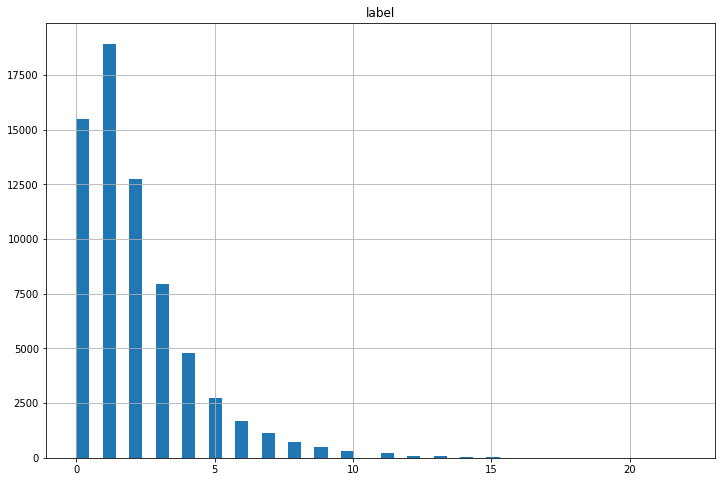

In [9]:
df1.hist(column="label", bins=CLASS*2, figsize=(12, 8))

In [10]:
df1['label'].value_counts().describe()

count       20.000000
mean      3373.300000
std       5772.821449
min          1.000000
25%         30.250000
50%        404.500000
75%       3258.250000
max      18938.000000
Name: label, dtype: float64

In [11]:
# df1.to_csv(f"test.csv", index=False)

### 1.2 AUGMENT

In [12]:
# ---------------------------------------------------------------- SHUFFLE DATA
SHUFFLE_DATA = 1
if SHUFFLE_DATA == 1:
    df = df.sample(frac=1).reset_index(drop=True)
# df

In [13]:
## DROP ERROR
# df1 = df[df.iloc[:, 1] > 0]
# df1.head

### 1.4 DATA to TENSOR

In [14]:
# data, label = v0_9_df2tensor(df1)

In [15]:
## ---------------------------------------------------------------- DATASET TO TENSOR
data_path = f"/media/z/0/MVPC10/CODE/pplcnt_model/labeling_tool/out"
data = []
label = []
for i in range(len(df1)):
    try:
        img = Image.open(f"{data_path}/{df1.iloc[i,0]}.png")
        data.append(list(img.getdata()))
        label.append(df1.iloc[i,1])
    except Exception as E:
        print(E)
    if i%10000 == 0:  print(i)

0
10000
20000
30000
40000
50000
60000


In [16]:
data = np.array(data)
data = data.reshape(data.shape[0], 80, 80, 1)
H, W = data.shape[1], data.shape[2]
print(H, W)

label = np.array(label)
label = label.reshape(label.shape[0], 1)

print(data.shape)
print(label.shape)
data.dtype


80 80
(67466, 80, 80, 1)
(67466, 1)


dtype('int64')

### 1.5 PROCESS

In [17]:
# set(data.reshape(-1))

In [18]:
## ---------------------------------------------------------------- SHUFFLE
# seed = 99
# np.random.seed(seed)
# np.random.shuffle(data)
# # np.random.seed(seed)
# np.random.shuffle(label)

## ---------------------------------------------------------------- LABEL NORMALIZE
# norm_label = label/CLASS
norm_label = label  ## NO NORMALIZE
# norm_label.dtype

## ---------------------------------------------------------------- DATA NORMALIZE
# print(data[0][0])
norm_data = data/MAX
# norm_data = data.astype("float")/MAX
# print(norm_data[0][0])


## ---------------------------------------------------------------- SPLIT
split1 = int(len(label)*0.96)
X1, X2 = norm_data[:split1], norm_data[split1:]
Y1, Y2 = norm_label[:split1], norm_label[split1:]
## VAL SPLIT
split2 = int(len(label)*0.9)
# X1, val_data = X1[:split2], X1[split2:]
# X2, val_label = X2[:split2], X2[split2:]



In [19]:
print(X1.shape)
print(Y1.shape)
print(X2.shape)
print(Y2.shape)

(64767, 80, 80, 1)
(64767, 1)
(2699, 80, 80, 1)
(2699, 1)


# 2. TRAIN

In [20]:
def make_inc():
    val = [0]
    def inc():
        val[0] += 1
        return val[0]
    return inc
inc = make_inc()

### 2.1. MODEL

In [21]:
MODEL_VERSION = f"v2.1"
## ---------------------------------------------------------------- SETUP
# size = input_shape - layer_shape + 1
## con(filter, (size), stride, padding, activation, name, input)

## ---------------------------------------------------------------- IN
input = Input(shape=(H, W, 1))

## ---------------------------------------------------------------- HEAD
x = con(64, 9, 1, 'valid', 'elu', 0.25, f'{inc()}', input)

## ---------------------------------------------------------------- BODY
# x = con(64, 9, 1, 'valid', 'elu', 0.25, f'{inc()}', input)
# x = con(64, 11, 1, 'valid', 'elu', 0.25, f'{inc()}', x)
# x = con(64, 9, 1, 'valid', 'elu', 0.25, f'{inc()}', x)
# x = con(64, 7, 1, 'valid', 'elu', 0.25, f'{inc()}', x)
# x = con(64, 5, 1, 'valid', 'elu', 0.25, f'{inc()}', x)

x = res(64, 3, 1, 'valid', 'elu', 0.25, f'{inc()}', x)
x = res(64, 3, 1, 'valid', 'elu', 0.25, f'{inc()}', x)
x = res(64, 3, 1, 'valid', 'elu', 0.25, f'{inc()}', x)
x = res(64, 3, 1, 'valid', 'elu', 0.25, f'{inc()}', x)
x = res(64, 3, 1, 'valid', 'elu', 0.25, f'{inc()}', x)
x = res(64, 3, 1, 'valid', 'elu', 0.25, f'{inc()}', x)
x = res(64, 3, 1, 'valid', 'elu', 0.25, f'{inc()}', x)
x = res(64, 3, 1, 'valid', 'elu', 0.25, f'{inc()}', x)


## ---------------------------------------------------------------- TAIL
x = Conv2D(1, (1,1), strides=2)(x)
x = Conv2D(1, (1,1), strides=2)(x)
# x = tf.reduce_mean(x, (1, 2))  #, axis=None, keepdims=False, name=None)
# x = Dropout(.5)(x)
x = Flatten()(x)

## ---------------------------------------------------------------- OUT
# output = Conv2D(1, (48, 48))(x)
# output = Dense(len(CLASS))(x)
output = Dense(1)(x)

## ---------------------------------------------------------------- FINAL
model = Model(input, output)


### 2.2. COMPILE

In [24]:
LOAD_MODEL = 0

if LOAD_MODEL == 0:

    ## ---------------------------------------------------------------- OPTIMIZER
    # lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    #         initial_learning_rate=0.001,
    #         decay_steps=100000,
    #         decay_rate=0.96,
    #         staircase=True)

    # lr_schedule = k.optimizers.schedules.CosineDecay(initial_learning_rate=1e-4,
    #                                                  decay_steps=EPOCH,
    #                                                  )

    # optimizer = optimizers.Adam(learning_rate=lr_schedule)
    optimizer = optimizers.Adam(learning_rate=0.0001)

    ## ---------------------------------------------------------------- LOSS
    # def adaptive_loss():
    #     pass
    # loss = losses.MeanAbsoluteError()
    # loss = losses.BinaryCrossentropy()
    loss = losses.MeanSquaredError()
    # loss = losses.SparseCategoricalCrossentropy()
    # loss = losses.BinaryFocalCrossentropy(  #apply_class_balancing=False,
            # alpha=0.25,
            # gamma=2.0,
            # from_logits=False,
            # label_smoothing=0.0,
            # axis=-1,
            # reduction=losses_utils.ReductionV2.AUTO,
            # name='binary_focal_crossentropy'
            # )

    ## ---------------------------------------------------------------- METRICS
    # metrics = ['accuracy']
    # metrics = [SparseCategoricalAccuracy()]
    metrics = [metrics.MeanSquaredError()]

    ## ---------------------------------------------------------------- COMPILE
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    model.summary()

elif LOAD_MODEL == 1:
    model_path = f"OUT/{MODEL_VERSION}/model/20221024-191637.h5"
    model = tf.keras.models.load_model(model_path)
    model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80, 80, 1)]  0           []                               
                                                                                                  
 1_C2 (Conv2D)                  (None, 72, 72, 64)   5248        ['input_1[0][0]']                
                                                                                                  
 1_BN (BatchNormalization)      (None, 72, 72, 64)   256         ['1_C2[0][0]']                   
                                                                                                  
 1_ACT (Activation)             (None, 72, 72, 64)   0           ['1_BN[0][0]']                   
                                                                                              

### 2.3. FIT

In [25]:
EPOCH = 64
BATCH = 32
ES = 16
# ES = EPOCH//2

## fit
log_path = f"OUT/{MODEL_VERSION}/logs/"+datetime.now().strftime("%Y%m%d-%H%M%S")
es = EarlyStopping(monitor="val_loss", patience=ES, verbose=2, mode='auto')
tensorboard_callback = TensorBoard(log_dir=log_path, histogram_freq=1)

history = model.fit(X1, Y1,
                    validation_split=0.1,
                    # validation_data=(val_data, val_label),
                    batch_size=BATCH,
                    epochs=EPOCH,
                    verbose=1,
                    callbacks=[es,
                               tensorboard_callback,
                               PlotLossesKeras(),
                               # PlotLossesKerasTF(),
                               ],
                    )

2022-10-26 01:51:10.661484: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2022-10-26 01:51:10.661505: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2022-10-26 01:51:10.732623: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2022-10-26 01:51:10.732793: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed


Epoch 1/64


2022-10-26 01:51:15.249419: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600
2022-10-26 01:51:15.715320: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-10-26 01:51:15.716192: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2022-10-26 01:51:15.716205: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2022-10-26 01:51:15.716240: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be 

   1/1822 [..............................] - ETA: 2:53:49 - loss: 18.8767 - mean_squared_error: 18.8767

2022-10-26 01:51:18.231605: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2022-10-26 01:51:18.231626: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.


   2/1822 [..............................] - ETA: 18:04 - loss: 17.4017 - mean_squared_error: 17.4017  

2022-10-26 01:51:18.724520: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2022-10-26 01:51:18.724968: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed
2022-10-26 01:51:18.755450: I tensorflow/core/profiler/backends/gpu/cupti_collector.cc:521]  GpuTracer has collected 1011 callback api events and 1076 activity events. 
2022-10-26 01:51:18.765111: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2022-10-26 01:51:18.775844: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: OUT/v2.1/logs/20221026-015110/train/plugins/profile/2022_10_26_01_51_18

2022-10-26 01:51:18.785321: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to OUT/v2.1/logs/20221026-015110/train/plugins/profile/2022_10_26_01_51_18/1.trace.json.gz
2022-10-26 01:51:18.817953: I tensorflow/core/profiler/rpc/client/save_profile.cc

  38/1822 [..............................] - ETA: 4:47 - loss: 9.7822 - mean_squared_error: 9.7822

KeyboardInterrupt: 

In [ ]:
# BATCH = 32
# EPOCH = 30
#
# lb = Y2.reshape(-1)
# has = {}
#
# # np.array(list(set(Y2.reshape(-1)))).astype(np.int64)
# ls_num = list(map(int, list(set(lb))))
# for n in ls_num:
#     has[n] = []
# for ind in range(len(lb)):
#     # ind는 label 인덱스
#     if len(has[lb[ind]]) < 30:
#         has[lb[ind]].append(ind)
#
# x_data = []
# y_data = []
# for key in has.keys():
#     for ind in has[key]:
#         x_data.append(Y1[ind])
#         y_data.append(Y2[ind])
#
# x_data = np.array(x_data).astype(np.float32)
# y_data = np.array(y_data).astype(np.float32)
# X1 = X1.astype(np.float32)
# X2 = X2.astype(np.float32)
#
# for i in range(30):
#     print(i)
#     history = model.fit(X1, X2,
#                         # validation_split=0.2,
#                         validation_data=(x_data, y_data),
#                         batch_size=BATCH,
#                         epochs=EPOCH,
#                         verbose=1,
#                         # callbacks=[es],)
#                         # callbacks=[es, tensorboard_callback], )
#                         )
#     model.save('asdf/' + str(i) + '.h5')

In [ ]:
## history to DF
hdf = pd.DataFrame(history.history)
hdf.keys()

## plot history
hdf.plot(figsize=(9, 6), grid=1, xlabel="epoch", label="accuracy")
plt.ylim([0, 2])
plt.show()


In [ ]:
# epo = 10
# model = tf.keras.models.load_model('asdf/' + str(epo) + '.h5')
# Y2.shape
#
# lb = Y2.reshape(-1)
# has = {}
#
# # np.array(list(set(Y2.reshape(-1)))).astype(np.int64)
#
#
# ls_num = list(map(int, list(set(lb))))
# for n in ls_num:
#     has[n] = []
#
# for ind in range(len(lb)):
#
#     # ind는 label 인덱스
#
#     if len(has[lb[ind]]) < 30:
#         has[lb[ind]].append(ind)
#
# ls_num
#
# x_data = []
# y_data = []
#
#
# for key in has.keys():
#     for ind in has[key]:
#         x_data.append(Y1[ind])
#         y_data.append(Y2[ind])
#
# x_data = np.array(x_data)
# y_data = np.array(y_data)
# x_data.shape
# y_data.shape
#
#
# result = np.argmax(model.predict(x_data), -1)
# cont = 0
# for ind in range(len(result)):
#     if result[ind] == y_data.reshape(-1)[ind]:
#         cont +=1
#
#
# cont
# print(len(ls_num))
# print(cont/len(result))



In [ ]:
SAVE_MODEL_PLOT = 1
MODEL_VERSION = f"v2.1"

if SAVE_MODEL_PLOT == 1:
    plot_model(model, to_file=f"OUT/{MODEL_VERSION}/plot/{MODEL_VERSION}_modelplot.png", show_shapes=True, show_layer_names=False, show_layer_activations=True)


# 3. EVALUATE

In [ ]:
loss, acc = model.evaluate(X2, Y2, verbose=1)

predict = model.predict(X2)


### 3.1 PROCESS

In [ ]:
predict1 = predict
n = len(predict)
F = 0
pp_li = []
for pp in np.arange(0.2180, 0.2220, 0.0001):
    predict1 = predict+pp
    for i in range(n):
        diff = abs(predict1[i].round(0).astype(int)-Y2[i])
        F += diff
    pp_li.append((pp,F))
    F = 0

for i in pp_li:
    print(i)

### 3.2 ACCURACY

In [ ]:
predict1 = predict + 0.22
n = len(predict)
wrong = 0
Y2_cnt = 0
# F_list = []
for i in range(n):
    Y2_cnt += Y2[i][0]
    diff = abs(predict1[i].round(0).astype(int)-Y2[i])[0]
    wrong += diff
    # F_list.append(diff[0])
print(f"error: {wrong}")
print(f"total: {Y2_cnt}")
print(f"acc:   {round((Y2_cnt-wrong)/Y2_cnt, 2)*100}%")


### 3.3 VISUALIZE

In [ ]:
n = 20
for i in range(0, n, 1):
    # if Y2[i][0] > 0.3:
    diff = abs(predict1[i].round(0).astype(int)-Y2[i])
    size = 10
    test_img = Image.fromarray((X2[i]*255).reshape(H,W)).convert('L').resize((W*size, H*size))
    print(f"pred: {predict1[i]}")
    print(f"labl: {Y2[i]}")
    print(f"diff: {diff}")
    display(test_img)


In [ ]:
if SAVE == 1:
    model_save_name = f"OUT/{MODEL_VERSION}/model/{datetime.now().strftime('%Y%m%d-%H%M%S')}.h5"
    model.save(model_save_name)

In [ ]:
# launch tensorboard @ localhost:6006
# if TENSORBOARD == 1:
#     %tensorboard --logdir logs/--host localhost --port 6006